In [1]:
def load_wind_data(data_path):
    
    wind_site_actual_df = pd.read_csv(
        Path(data_path, 'Wind', 'Actual',
             'wind_actual_1h_site_2019_utc.csv'),
        parse_dates=['Time'], index_col='Time'
        )

    wind_site_forecast_df = pd.read_csv(
        Path(data_path, 'Wind', 'Day-ahead',
             'wind_day_ahead_forecast_site_2019_utc.csv'),
        parse_dates=['Issue_time', 'Forecast_time']
        )
    
    wind_meta_df = pd.read_csv(Path(data_path, 'MetaData', 'wind_meta.csv'))

    return wind_site_actual_df, wind_site_forecast_df, wind_meta_df

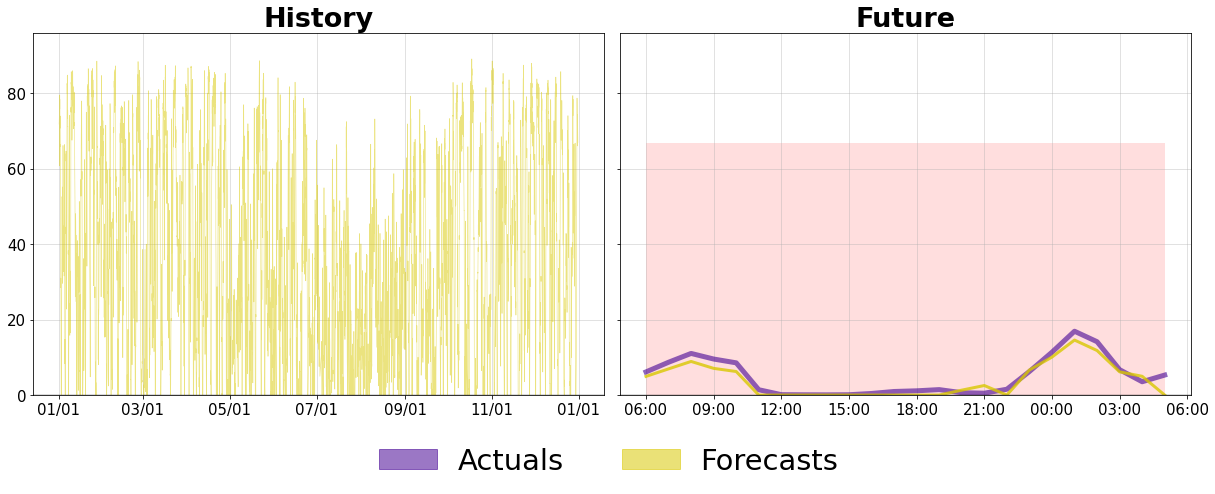

In [4]:
from pathlib import Path
import pandas as pd
from pgscen.command_line import (split_actuals_hist_future, split_forecasts_hist_future)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.figsize'] = [19, 11]
from IPython.display import display


start_date = '2019-07-03'
data_dir = '../data/NYISO/'

scenario_count = 1000
scen_start_time = pd.to_datetime(' '.join([start_date, "06:00:00"]), utc=True)
scen_timesteps = pd.date_range(start=scen_start_time, periods=24, freq='H')

wind_site_actual_df, wind_site_forecast_df, wind_meta_df = load_wind_data(data_dir)

(wind_site_actual_hists,
     wind_site_actual_futures) = split_actuals_hist_future(
            wind_site_actual_df, scen_timesteps, in_sample=True)

(wind_site_forecast_hists,
     wind_site_forecast_futures) = split_forecasts_hist_future(
            wind_site_forecast_df, scen_timesteps, in_sample=True)

fig, (hist_ax, future_ax) = plt.subplots(figsize=(17, 6),
                                         nrows=1, ncols=2, sharey=True)

title_args = dict(weight='semibold', size=27)
actual_clr, fcst_clr = "#430093", "#D9C800"
plt_asset = wind_site_actual_df.columns[71]

hist_ax.set_title("History", **title_args)
hist_ax.plot(wind_site_actual_hists[plt_asset][8748:],
             c=actual_clr, lw=1, alpha=0.6)
hist_ax.plot(wind_site_forecast_hists['Forecast_time'],
             wind_site_forecast_hists[plt_asset],
             c=fcst_clr, lw=0.6, alpha=0.5)

future_ax.set_title("Future", **title_args)
future_ax.plot(wind_site_actual_futures[plt_asset],
               c=actual_clr, lw=5, alpha=0.6)
future_ax.plot(wind_site_forecast_futures['Forecast_time'],
               wind_site_forecast_futures[plt_asset],
               c=fcst_clr, lw=3, alpha=0.8)
future_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

future_ax.fill_between(wind_site_actual_futures.index[:24],
                       wind_site_actual_futures[plt_asset][:24].min() - 50,
                       wind_site_actual_futures[plt_asset][:24].max() + 50,
                       facecolor='red', edgecolor='none', alpha=0.13)

hist_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
future_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

for ax in [hist_ax, future_ax]:
    ax.tick_params(which='both', labelsize=15)
    ax.grid(linewidth=0.9, alpha=0.41)
    ax.axhline(0, lw=1.3, c='black', alpha=1)
    ax.set_ylim((0, ax.get_ylim()[1]))

lgnd_ptchs = [Patch(color=actual_clr, alpha=0.53, label="Actuals"),
              Patch(color=fcst_clr, alpha=0.53, label="Forecasts")]

_ = fig.legend(handles=lgnd_ptchs, frameon=False, fontsize=29, ncol=2, loc=8,
               bbox_to_anchor=(0.5, -0.17), handletextpad=0.7)
fig.tight_layout(w_pad=1)

,EI Melville,EI Oceanside,EI Oceanside 2,EI Steinway 1,EI Steinway 2,EI Sunset Park,East Wind 1
EI Melville,0.00,0.92,0.92,1.18,1.18,1.29,1.11
EI Oceanside,0.92,0.00,0.00,0.26,0.26,0.38,0.19
EI Oceanside 2,0.92,0.00,0.00,0.26,0.26,0.38,0.19
EI Steinway 1,1.18,0.26,0.26,0.00,0.00,0.18,0.07
EI Steinway 2,1.18,0.26,0.26,0.00,0.00,0.18,0.07
EI Sunset Park,1.29,0.38,0.38,0.18,0.18,0.00,0.22
East Wind 1,1.11,0.19,0.19,0.07,0.07,0.22,0.00


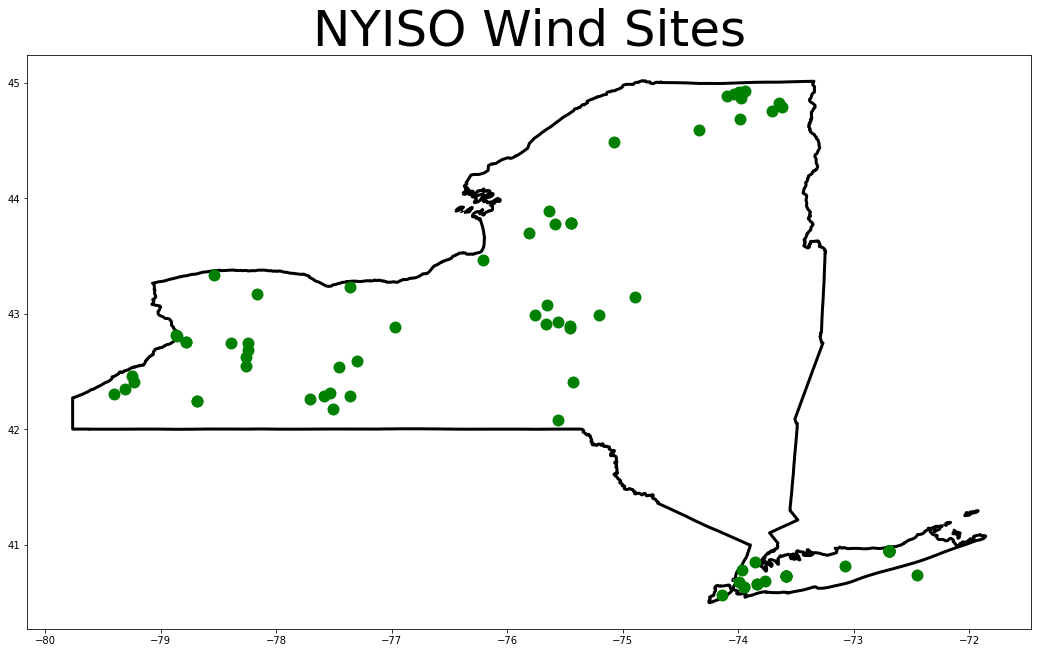

In [31]:
from pgscen.engine import GeminiEngine

ge = GeminiEngine(wind_site_actual_hists, wind_site_forecast_hists,
                  scen_start_time, wind_meta_df, 'wind')


import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    ge.meta_df, geometry=[Point(xy) for xy in zip(ge.meta_df['longitude'],
                                                  ge.meta_df['latitude'])]
    )

us = gpd.read_file('../data/Map/cb_2018_us_state_500k.zip')
ny = us[us['STUSPS']=='NY']

ax = ny.plot(facecolor="none", edgecolor='black', linewidth=3, figsize=(18, 18))
gdf.plot(ax=ax, marker='o', linewidth=0, markersize=143, c='green')
_ = plt.title('NYISO Wind Sites', fontsize=50)

dist = ge.asset_distance()
display(dist.iloc[24:31, 24:31].round(2))

ge.fit(dist.values / dist.values.max(), 0.05)

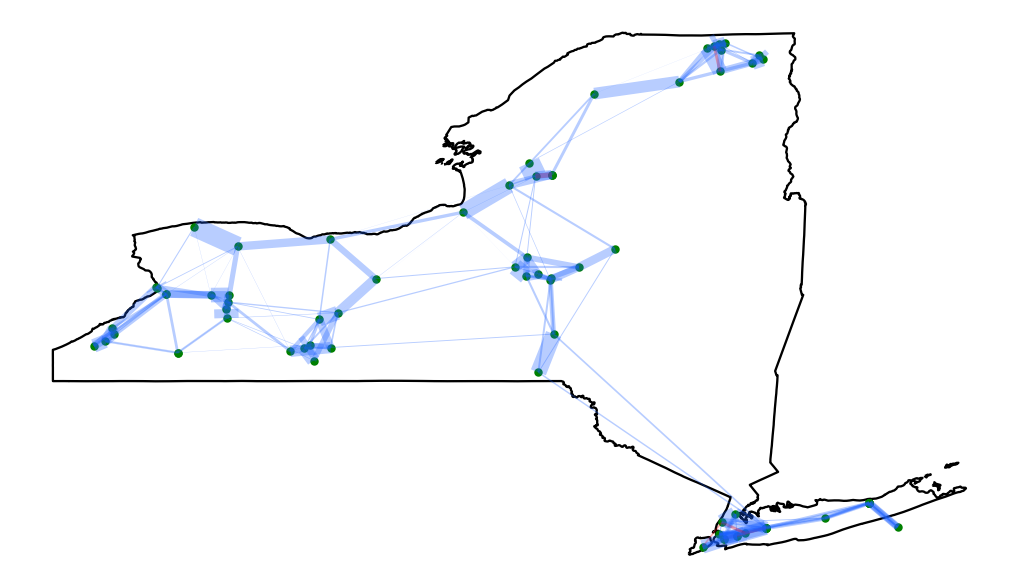

In [32]:
import numpy as np
from itertools import combinations as combn
from shapely.geometry import LineString


asset_cov = ge.model.asset_cov
prec_mat = np.linalg.inv(asset_cov)
pcor_mat = -prec_mat / np.sqrt(np.outer(np.diag(prec_mat), np.diag(prec_mat)))

cnct_dict = {
    (asset1, asset2): {
        'geometry': LineString([gdf.geometry[asset1], gdf.geometry[asset2]]),
        'pcor_val': pcor_mat[i, j]
        }
    for (i, asset1), (j, asset2) in combn(enumerate(asset_cov.index), 2)
    if np.abs(pcor_mat[i, j]) >= 0.02
    }

edges_gdf = gpd.GeoDataFrame(cnct_dict).transpose()
ax = ny.plot(facecolor="none", edgecolor='black', figsize=(18, 18), linewidth=2.3)
gdf.plot(ax=ax, marker='o', linewidth=0, markersize=71, c='green')

sign_vec = ['#1A5FFF' if val > 0 else "#FF0000" for val in edges_gdf.pcor_val]
edges_gdf.plot(ax=ax, color=sign_vec,
               linewidth=(edges_gdf.pcor_val - 0.02) * 40, alpha=0.31)

_ = ax.axis('off')

In [33]:
ge.create_scenario(scenario_count, wind_site_forecast_futures)

In [35]:
from ipywidgets import interact, Dropdown
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_wind_scenarios(wind_site):
    ax = ny.plot(facecolor="none", edgecolor='black', figsize=(18, 18), linewidth=2.3)

    gdf.plot(ax=ax, marker='o', linewidth=0, markersize=71, c='green')
    edges_gdf.plot(ax=ax, color=sign_vec,
                   linewidth=(edges_gdf.pcor_val - 0.05) * 53, alpha=0.31)

    cntr_x, cntr_y = ge.meta_df.longitude.mean(), ge.meta_df.latitude.mean()
    site_x, site_y = ge.meta_df.loc[wind_site, ['longitude', 'latitude']]
    xdiff, ydiff = site_x - cntr_x, site_y - cntr_y

    cntr_dist = (xdiff ** 2 + ydiff ** 2) ** 0.5
    site_cos, site_sin = xdiff / cntr_dist, ydiff / cntr_dist
    scen_x, scen_y = cntr_x + 8.5 * site_cos, cntr_y + 8.5 * site_sin

    scen_size = 7.5, 4
    scen_bbox = (scen_x - scen_size[0] / 2, scen_y - scen_size[1] / 2,
                 scen_size[0], scen_size[1])

    scen_ax = inset_axes(ax, width='100%', height='100%',
                         bbox_to_anchor=scen_bbox, bbox_transform=ax.transData,
                         loc=10, borderpad=0)
    
    ax.plot([site_x + 0 * site_cos, scen_x - 3.8 * site_cos],
            [site_y + 0 * site_sin, scen_y - 2 * site_sin],
            linewidth=4.3, c='black', alpha=0.53, linestyle='dotted')
    
    for i in range(scenario_count):
        scen_ax.plot(ge.scenarios['wind'].iloc[i][wind_site],
                     c='black', alpha=0.13, lw=0.2)

    plt_fcst = ge.forecasts['wind'][wind_site]
    scen_ax.plot(plt_fcst, c=fcst_clr, alpha=0.47, lw=4.1)
    scen_ax.plot(wind_site_actual_futures.loc[plt_fcst.index, wind_site],
                 c=actual_clr, alpha=0.47, lw=4.1)

    scen_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    scen_ax.tick_params(axis='both', labelsize=17)
    scen_ax.grid(linewidth=0.9, alpha=0.41)
    scen_ax.set_ylim((0, scen_ax.get_ylim()[1]))

    quant_df = ge.scenarios['wind'][wind_site].quantile([0.25, 0.75])
    scen_ax.fill_between(quant_df.columns, quant_df.iloc[0], quant_df.iloc[1],
                         color='red', alpha=0.31)

    lgnd_ptchs = [Patch(color='black', alpha=0.23, label="Scenarios"),
                  Patch(color='red', alpha=0.41, label="Interquartile Range"),
                  Patch(color=fcst_clr, alpha=0.81, label="Forecast"),
                  Patch(color=actual_clr, alpha=0.81, label="Actual")]

    _ = scen_ax.legend(handles=lgnd_ptchs, frameon=False,
                       bbox_to_anchor=(0.5, 1), loc=8,
                       fontsize=13, ncol=4, handletextpad=0.5)

    ax.axis('off')

    
w = Dropdown(options=ge.asset_list, description="Scenarios for generator:",
             layout={'align_self': 'center'}, style={'description_width': 'initial'},
             disabled=False)
_ = interact(plot_wind_scenarios, wind_site=w)

interactive(children=(Dropdown(description='Scenarios for generator:', layout=Layout(align_self='center'), opt…